In [1]:
import subprocess
import sys

# List of required packages
required_packages = [
    "pickle", "numpy", "keybert", "tqdm", "pandas", "torch", "sentence_transformers"
]

def install_package(package):
    """Installs a package using pip if it's not already installed."""
    try:
        __import__(package)
        print(f"{package} is already installed.")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Check and install missing packages
for package in required_packages:
    install_package(package)

pickle is already installed.
numpy is already installed.


C:\Users\aless\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\aless\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\_param_validation.py:11: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.sparse import csr_matrix, issparse


keybert is already installed.
tqdm is already installed.
pandas is already installed.
torch is already installed.
sentence_transformers is already installed.


In [2]:
import pickle
import numpy as np
import pandas as pd
import torch

from sentence_transformers import SentenceTransformer
from keybert import KeyBERT
from tqdm import tqdm
from KeyBertMetadata import KeyBERTMetadata

import warnings
warnings.filterwarnings('ignore')

In [3]:
# File path
file_path = "../Dataset/Reviews_By_Movie/Parasite.pkl"


with open(file_path, 'rb') as file:
  parasite_reviews_df = pickle.load(file)

print("Loaded dataset:")
display(parasite_reviews_df.head(10))


Loaded dataset:


,Review_ID,Movie_ID,Movie_Title,Rating,Review_Date,Review_Title,Review_Text,Helpful_Votes,Total_Votes,Preprocessed_Review
36192,9637661,tt6751668,Parasite,5.0,23 February 2024,"Solid Film Craftsmanship, Trash Story",I'm genuinely baffled this film won not only b...,3.0,8.0,I'm genuinely baffled this film won not only b...
36193,5510542,tt6751668,Parasite,10.0,26 February 2020,MASTERPIECE,Just watch it. It has everything; entertainmen...,3.0,5.0,Just watch it. It has everything; entertainmen...
36194,5182892,tt6751668,Parasite,10.0,12 October 2019,First Hit: I really enjoyed this story as it d...,First Hit: I really enjoyed this story as it d...,24.0,40.0,First Hit: I really enjoyed this story as it d...
36195,5499682,tt6751668,Parasite,9.0,21 February 2020,If you love cliché stories this movie is not f...,I was not expecting that much of this movie. N...,2.0,5.0,I was not expecting that much of this movie. N...
36196,6094155,tt6751668,Parasite,8.0,14 September 2020,Amazing.,"Good acting, cinematography, twists and screen...",0.0,0.0,"Good acting, cinematography, twists and screen..."
36197,6432630,tt6751668,Parasite,8.0,1 January 2021,not my favorit movie but I recommended,"I like this movie but the ending, everything i...",0.0,1.0,"I like this movie but the ending, everything i..."
36198,8575840,tt6751668,Parasite,10.0,29 September 2022,"Parasite has a unique originality, unmissable,...",We can say that it is a film without a defined...,2.0,5.0,We can say that it is a film without a defined...
36199,5479460,tt6751668,Parasite,1.0,12 February 2020,I still can't believe I finished to watch this...,Worst movie by far I have ever watched.\nPlot ...,80.0,154.0,Worst movie by far I have ever watched. Plot i...
36200,5455102,tt6751668,Parasite,9.0,2 February 2020,CROSSING THE LINE,Rooting for an impoverished but resourceful un...,10.0,15.0,Rooting for an impoverished but resourceful un...
36201,5497707,tt6751668,Parasite,4.0,20 February 2020,Average,"So to me, the movie was really average. It fai...",2.0,8.0,"So to me, the movie was really average. It fai..."


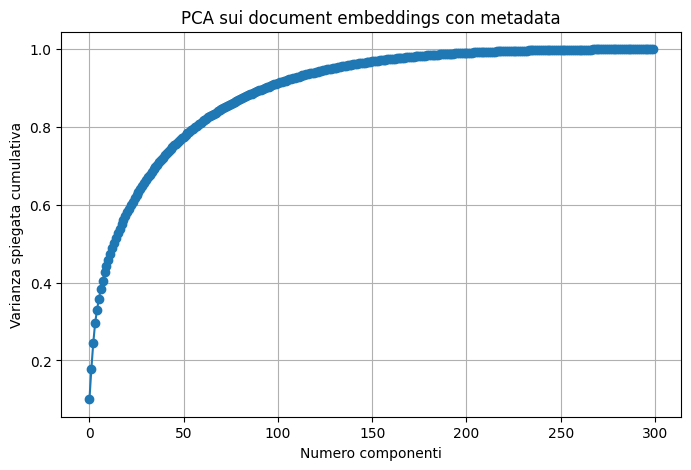

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from KeyBertMetadata import KeyBERTMetadata
from sklearn.decomposition import PCA

# Inizializza il modello KeyBERT con metadati
model = KeyBERTMetadata(model=SentenceTransformer("all-MiniLM-L6-v2"))

# Estrai un sottoinsieme coerente
df_subset = parasite_reviews_df.head(301)

# Metadati e testi dallo stesso subset
metadata = model.extract_metadata(df_subset, alpha=0.3)
docs = df_subset["Preprocessed_Review"].astype(str).tolist()


# Estrai document embeddings con metadati
doc_embeddings, _ = model.extract_embeddings_mean(
    docs,
    metadata=metadata,
    keyphrase_ngram_range=(1, 2),
    stop_words='english'
)

# PCA per analisi dimensionale
pca = PCA(n_components=300)
pca_result = pca.fit_transform(doc_embeddings)

# Visualizzazione varianza spiegata
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Numero componenti')
plt.ylabel('Varianza spiegata cumulativa')
plt.title('PCA sui document embeddings con metadata')
plt.grid(True)
plt.show()


In [5]:
# Ogni riga di pca.components_ è una componente principale
# Ogni colonna corrisponde a una dimensione dell'embedding originale
loadings = pca.components_

# Dimensione totale dell'embedding (inclusi i metadati)
n_features = doc_embeddings.shape[1]

# Calcoliamo la "forza media" per ciascuna dimensione
avg_contribution = np.mean(np.abs(loadings), axis=0)

# Visualizziamo le dimensioni più influenti
top_indices = np.argsort(avg_contribution)[::-1][:]

for idx in top_indices:
    print(f"Dimensione {idx}: contributo medio {avg_contribution[idx]:.4f}")


Dimensione 20: contributo medio 0.0439
Dimensione 309: contributo medio 0.0433
Dimensione 260: contributo medio 0.0433
Dimensione 381: contributo medio 0.0432
Dimensione 308: contributo medio 0.0431
Dimensione 87: contributo medio 0.0431
Dimensione 208: contributo medio 0.0431
Dimensione 311: contributo medio 0.0431
Dimensione 55: contributo medio 0.0430
Dimensione 317: contributo medio 0.0430
Dimensione 146: contributo medio 0.0429
Dimensione 342: contributo medio 0.0428
Dimensione 125: contributo medio 0.0428
Dimensione 149: contributo medio 0.0426
Dimensione 164: contributo medio 0.0426
Dimensione 354: contributo medio 0.0426
Dimensione 349: contributo medio 0.0425
Dimensione 356: contributo medio 0.0425
Dimensione 156: contributo medio 0.0425
Dimensione 236: contributo medio 0.0425
Dimensione 294: contributo medio 0.0425
Dimensione 167: contributo medio 0.0425
Dimensione 253: contributo medio 0.0424
Dimensione 202: contributo medio 0.0424
Dimensione 246: contributo medio 0.0424
Dim

In [8]:
# Indici delle dimensioni dei metadati
meta_indices = [384, 385, 386, 387]

for idx in meta_indices:
    print(f"Dimensione {idx} (metadato): contributo medio {avg_contribution[idx]:.6f}")


Dimensione 384 (metadato): contributo medio 0.025912
Dimensione 385 (metadato): contributo medio 0.041020
Dimensione 386 (metadato): contributo medio 0.032257
Dimensione 387 (metadato): contributo medio 0.037173
